In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tf_agents.networks import q_network
from tf_agents.agents.ddpg import ddpg_agent, critic_network
from tf_agents.specs import tensor_spec
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents import utils
from tf_agents.trajectories import time_step as ts

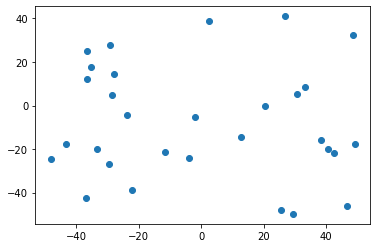

In [2]:
# Number of sensing locations
locations_num = 30

# Size of the map (the map is squared)
map_size = 100.0

# Coordinates of the sensing locations
sensing_locations = (np.random.rand(locations_num, 2) * map_size) - (map_size / 2)

_ = plt.scatter(sensing_locations[:,0], sensing_locations[:,1])

In [3]:
# Number of drones
drones_num = 10

# Length of a single cycle in seconds
cycle_length = 1.0

# Maximum speed of drones in points / seconds
max_speed = 0.5

# Definition of the global state

# Coordinates of the drones locations
drones_locations = np.zeros((drones_num, 2), dtype=float)

# Amounts of sensing data to send per drone
sensing_data_amounts = np.zeros(drones_num, dtype=float)

# AoIs (age of information) per sensing location. Denotes the last cycle in which
# any drone performed sensing at a specific sensing location
aois = np.zeros(locations_num, dtype=int)

# Indices of the chosen locations per drone. They are chosen in the decision cycles.
# The initial values are not significant.
chosen_locations = np.zeros(drones_num, dtype=int)


# Returns the AoI of the given location
def get_location_aoi(cycle, location_index):
    return (cycle * cycle_length) - ((aois[location_index] // cycle_length) * cycle_length)

# Returns the trajectory for the current cycle 
def get_trajectory(drone_index):
    chosen_location_index = chosen_locations[drone_index]
    chosen_location = sensing_locations[chosen_location_index]
    drone_location = drones_locations[drone_index]
    distance = np.linalg.norm(chosen_location - drone_location)
    if distance <= max_speed * cycle_length:
        return chosen_location - drone_location
    else:
        return ((chosen_location - drone_location) / distance) * max_speed * cycle_length

In [4]:
# Simplifying transmission step: only considering a bandwidth and a total amount of
# data for every location. Assumption: tasks are equal, so the amount of data is the same.

# Transmission bandwidth per cycle
bandwidth = 0.5

# Total amount of sensing data per location
total_location_data = 3.0

# Amount of data transmissible per cycle 
data_transmission_cycle = bandwidth * cycle_length

In [12]:
'''
Using Deep Q Learning. Having current drone location (x,y), 
potential sensing location (x',y') (could also directly consider distance
between the two locations) and AoI of the sensing location
as features, the network should output a Q value. The higher
the value the better this sensing location choice. Executing the network
at the decision cycle for every sensing location and choosing the one
that outputs the highest Q value. After each decision, the Q network
should be updated by performing backpropagation and considering the error.
'''

class DurpEnv(py_environment.PyEnvironment):
    def __init__(self):
        self._action_spec = tensor_spec.BoundedTensorSpec(
            shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
        self._observation_spec = tensor_spec.TensorSpec(
            shape=(2,), dtype=np.int32, name='observation')
        self._state = tf.constant([0])
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = 0
        self._episode_ended = False
        return ts.restart(tf.constant([self._state], dtype=np.int32))

    def _step(self, action):

        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()

        # Make sure episodes don't go on forever.
        if action == 1:
            self._episode_ended = True
        elif action == 0:
            new_card = np.random.randint(1, 11)
            self._state += new_card
        else:
            raise ValueError('`action` should be 0 or 1.')

        if self._episode_ended or self._state >= 21:
            reward = self._state - 21 if self._state <= 21 else -21
            return ts.termination(tf.constant([self._state], dtype=np.int32), reward)
        else:
            return ts.transition(
                tf.constant([self._state], dtype=np.int32), reward=0.0, discount=1.0)


learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

durp_env = DurpEnv()

train_env = tf_py_environment.TFPyEnvironment(durp_env)

net = critic_network.CriticNetwork(
    train_env.observation_spec(), 
    output_activation_fn=tf.keras.activations.sigmoid,
    activation_fn=tf.nn.relu,
    name='DurpNetwork'
)

'''
q_net = q_network.QNetwork(
  train_env.observation_spec(),
  train_env.action_spec(),
  fc_layer_params=(100,))'''

agent = ddpg_agent.DdpgAgent(
  train_env.time_step_spec(),
  train_env.action_spec(),
  actor_network=None,
  critic_network=net,
  critic_optimizer=optimizer,
  td_errors_loss_fn=utils.common.element_wise_squared_loss,
  train_step_counter=tf.Variable(0))

agent.initialize()

TypeError: Expected observation and reward specs to both be either tensor or array specs, but saw spec values TensorSpec(shape=(2,), dtype=tf.int32, name='observation') vs. ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
  In call to configurable 'BatchedPyEnvironment' (<class 'tf_agents.environments.batched_py_environment.BatchedPyEnvironment'>)
  In call to configurable 'TFPyEnvironment' (<class 'tf_agents.environments.tf_py_environment.TFPyEnvironment'>)

In [40]:
# Number of total cycles for the simulation
cycles_num = 500

# Running simulation (one cycle at a time for every drone)
for cycle in range(1, cycles_num + 1):
    for drone in range(drones_num):
        # TODO: select next location in some way during decision cycle
        aoi = get_location_aoi(cycle, chosen_locations[drone])
        if aoi == cycle_length: # Decision cycle
            pass
        elif (drones_locations[drone] != chosen_locations[drone]).all(): # Empty cycle
            trajectory = get_trajectory(drone)
            new_location = drones_locations[drone] + trajectory
            # Updating drone location
            np.insert(drones_locations, drone, new_location, axis=0)
        elif sensing_data_amounts[drone] == 0.0: # Sensing cycle
            # Updating drone sensing data remaining amount
            np.insert(sensing_data_amounts, drone, total_location_data, axis=0)
        else: # Transmission cycle
            # Updating drone sensing data remaining amount
            np.insert(sensing_data_amounts, drone, 
                np.max(sensing_data_amounts[drone] - data_transmission_cycle, 0.0), axis=0)
            # Updating the AoI if the transmission has been completed
            if sensing_data_amounts[drone] == 0.0:
                np.insert(aois, chosen_locations[drone], cycle, axis=0)

